In [1]:
%load_ext autoreload
%autoreload 2

# Imports and load data

In [2]:

import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import mlflow
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt

# Load .env and MLflow
load_dotenv()
mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))
mlflow.set_experiment("citibike_full_lag_fe_imp_lgbm")


2025/05/10 07:43:53 INFO mlflow.tracking.fluent: Experiment with name 'citibike_full_lag_fe_imp_lgbm' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/daa3e2cf0ef5438bafed58ef1227116e', creation_time=1746877433862, experiment_id='2', last_update_time=1746877433862, lifecycle_stage='active', name='citibike_full_lag_fe_imp_lgbm', tags={}>

# Load full lag data

In [3]:
df = pd.read_parquet("../data/processed/2023/citibike_lag672_top3.parquet")
df['start_hour'] = pd.to_datetime(df['start_hour'])
print(df.shape)
df.head()


(24264, 687)


,start_station_id,start_hour,rides,hour,dow,doy,sin_hour,cos_hour,sin_dow,cos_dow,...,lag_662,lag_663,lag_664,lag_665,lag_666,lag_667,lag_668,lag_669,lag_670,lag_671
0,5329.03,2023-01-29 00:00:00,0,0,6,29,0.000000,1.000000,-0.781831,0.62349,...,15.0,9.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,5329.03,2023-01-29 01:00:00,0,1,6,29,0.258819,0.965926,-0.781831,0.62349,...,12.0,15.0,9.0,7.0,1.0,1.0,0.0,0.0,1.0,0.0
2,5329.03,2023-01-29 02:00:00,1,2,6,29,0.500000,0.866025,-0.781831,0.62349,...,10.0,12.0,15.0,9.0,7.0,1.0,1.0,0.0,0.0,1.0
3,5329.03,2023-01-29 03:00:00,0,3,6,29,0.707107,0.707107,-0.781831,0.62349,...,25.0,10.0,12.0,15.0,9.0,7.0,1.0,1.0,0.0,0.0
4,5329.03,2023-01-29 04:00:00,0,4,6,29,0.866025,0.500000,-0.781831,0.62349,...,23.0,25.0,10.0,12.0,15.0,9.0,7.0,1.0,1.0,0.0


# Drop duplicates if any

In [4]:
num_duplicates = df.duplicated(subset=["start_station_id", "start_hour"]).sum()
print(f"🔍 Duplicate rows (by start_station_id + start_hour): {num_duplicates}")
df = df.drop_duplicates(subset=["start_station_id", "start_hour"])

🔍 Duplicate rows (by start_station_id + start_hour): 0


# Feature and target cols

In [5]:
# --- Feature & target columns ---
feature_cols = [col for col in df.columns if col.startswith("lag_")]
target_col = "target_t_plus_1"

# Time-based split: train = before Dec 2023, test = Dec onwards

In [6]:
cutoff = datetime(2023, 12, 1)
train_df = df[df["start_hour"] < cutoff].copy()
test_df = df[df["start_hour"] >= cutoff].copy()

# Drop rows with missing values *after* splitting

In [7]:
# Drop rows with missing values before splitting
drop_cols = feature_cols + [target_col]
train_df = train_df.dropna(subset=drop_cols)
test_df = test_df.dropna(subset=drop_cols)

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

In [8]:

print("Shapes after time-based split and NaN drop:")
print("X_train:", X_train.shape, "| y_train:", y_train.shape)
print("X_test:", X_test.shape, "| y_test:", y_test.shape)

Shapes after time-based split and NaN drop:
X_train: (22032, 672) | y_train: (22032,)
X_test: (2229, 672) | y_test: (2229,)


# Train LightGBM Model

In [9]:
model = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    objective="regression_l1",
    random_state=42,
)

model.fit(X_train, y_train)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 64448
[LightGBM] [Info] Number of data points in the train set: 22032, number of used features: 672
[LightGBM] [Info] Start training from score 10.000000


LGBMRegressor(n_estimators=200, objective='regression_l1', random_state=42)

# Select top 10 features by importance

In [11]:
importances = model.feature_importances_
importance_df = pd.DataFrame({"feature": feature_cols, "importance": importances})
importance_df = importance_df.sort_values("importance", ascending=False)
top_features = importance_df.head(10)["feature"].tolist()

print("🔝 Top 10 Features:")
print(importance_df.head(10))

🔝 Top 10 Features:
     feature  importance
0      lag_1         242
1     lag_24         126
2    lag_168         122
4      lag_2         105
336  lag_336          84
11     lag_9          69
504  lag_504          57
5      lag_3          55
3    lag_672          47
503  lag_503          40


# Retrain model with top 10 features

In [12]:
model_top10 = lgb.LGBMRegressor(
    n_estimators=200,
    learning_rate=0.1,
    objective="regression_l1",
    random_state=42,
)
model_top10.fit(X_train[top_features], y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 959
[LightGBM] [Info] Number of data points in the train set: 22032, number of used features: 10
[LightGBM] [Info] Start training from score 10.000000


LGBMRegressor(n_estimators=200, objective='regression_l1', random_state=42)

# Evaluate

In [13]:
y_pred_train = model_top10.predict(X_train[top_features])
y_pred_test = model_top10.predict(X_test[top_features])
train_mae = mean_absolute_error(y_train, y_pred_train)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Top-10 Feature Model — Train MAE: {train_mae:.2f}")
print(f"Top-10 Feature Model — Test MAE: {test_mae:.2f}")

Top-10 Feature Model — Train MAE: 3.87
Top-10 Feature Model — Test MAE: 3.27


# Log to MLflow

In [16]:
with mlflow.start_run(run_name="lightgbm_top10_features") as run:
    mlflow.log_param("model", "LightGBM")
    mlflow.log_param("n_features", 10)
    mlflow.log_param("selected_features", ", ".join(top_features))
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.sklearn.log_model(model_top10, "model")
    print("🔗 View run at:")
    print(f"{mlflow.get_tracking_uri()}/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")


2025/05/10 07:49:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🔗 View run at:
https://dagshub.com/Vr1155/citibike.mlflow/#/experiments/2/runs/f0ba14b39cb24ba49aabf4a2c7d82033
🏃 View run lightgbm_top10_features at: https://dagshub.com/Vr1155/citibike.mlflow/#/experiments/2/runs/f0ba14b39cb24ba49aabf4a2c7d82033
🧪 View experiment at: https://dagshub.com/Vr1155/citibike.mlflow/#/experiments/2


# Optional Plot Predictions

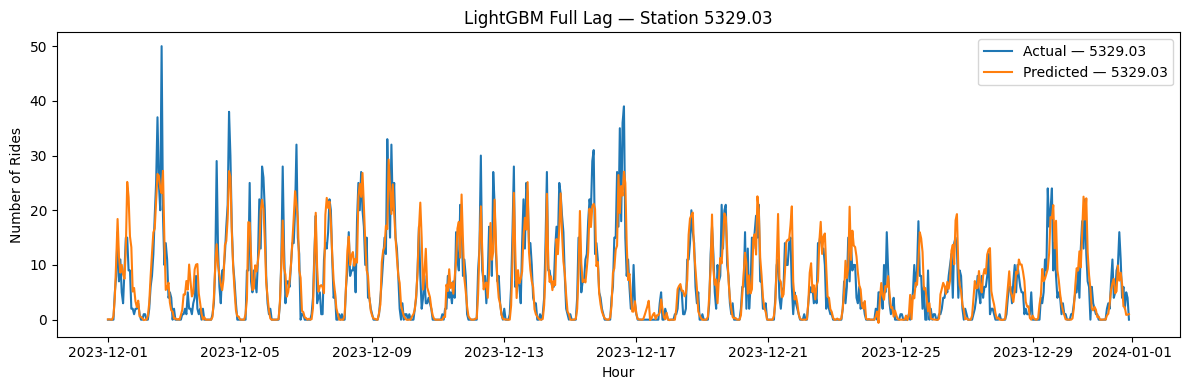

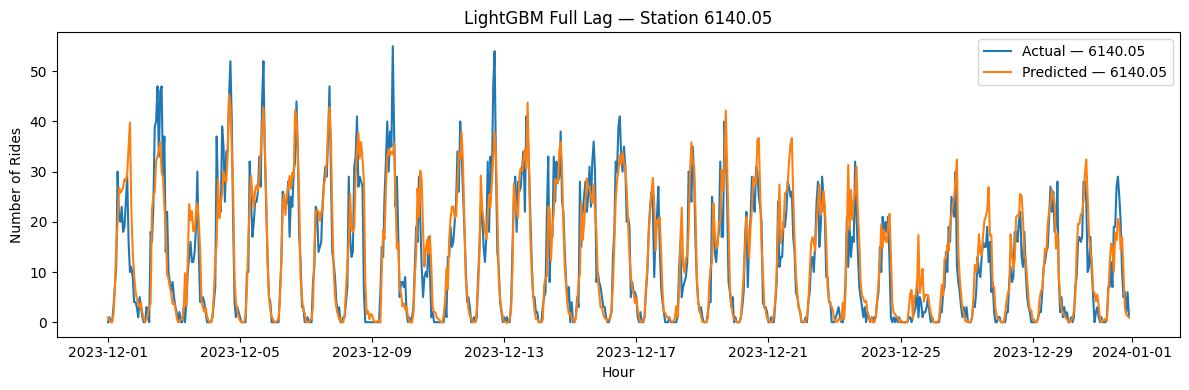

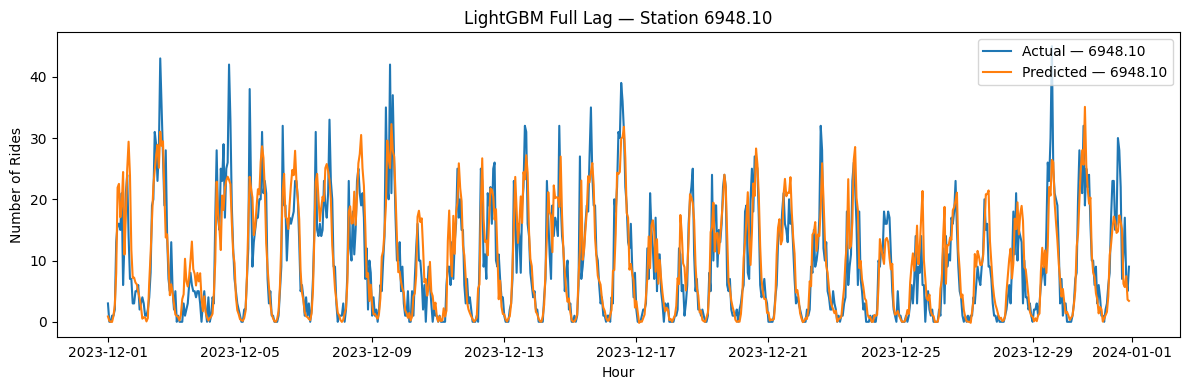

In [14]:

# --- Plot: Per Station ---
unique_stations = test_df["start_station_id"].unique()

for station_id in unique_stations:
    station_mask = test_df["start_station_id"] == station_id
    timestamps = test_df.loc[station_mask, "start_hour"]
    y_true = y_test[station_mask]
    y_pred = y_pred_test[station_mask]

    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, y_true, label=f"Actual — {station_id}")
    plt.plot(timestamps, y_pred, label=f"Predicted — {station_id}")
    plt.title(f"LightGBM Full Lag — Station {station_id}")
    plt.xlabel("Hour")
    plt.ylabel("Number of Rides")
    plt.legend()
    plt.tight_layout()
    plt.show()

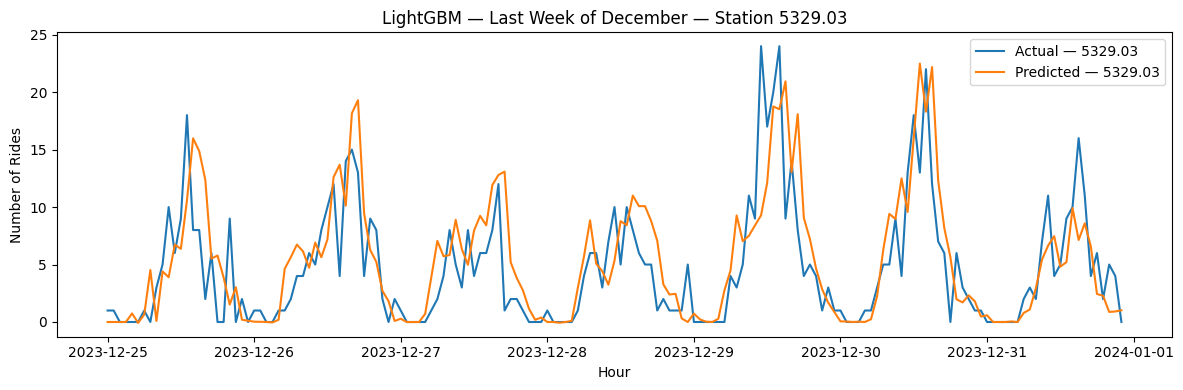

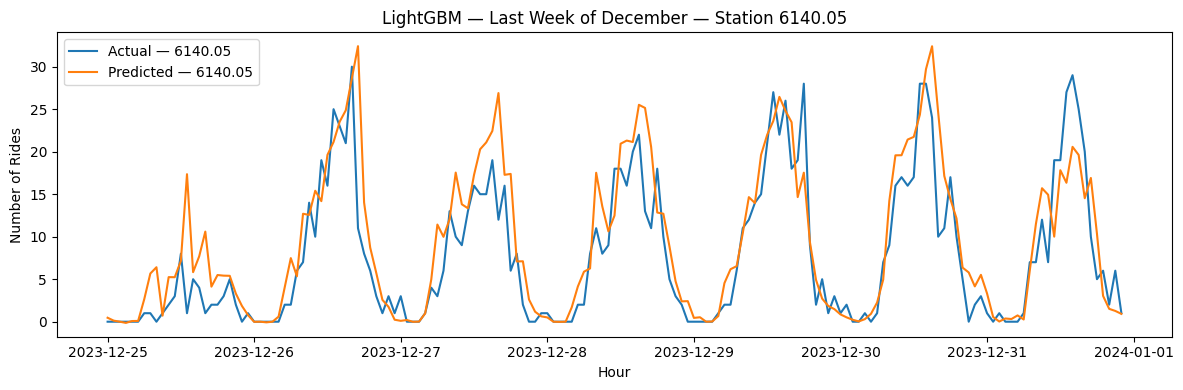

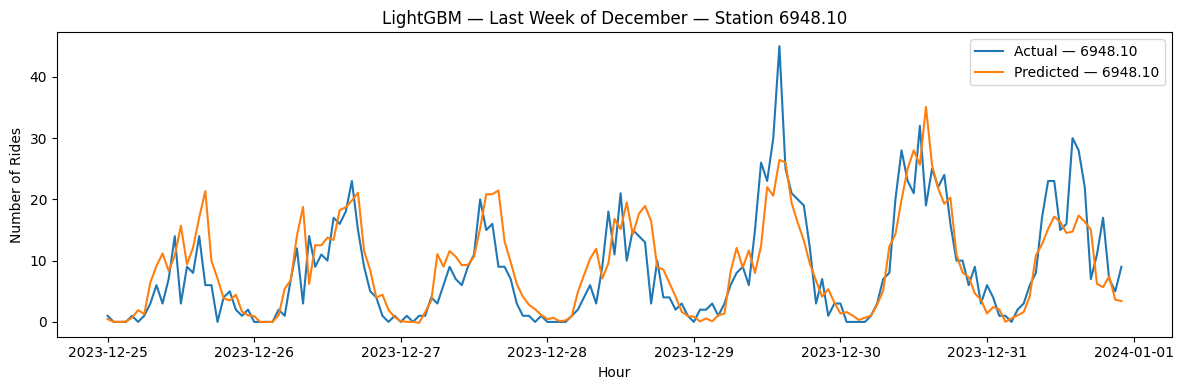

In [15]:
# --- Additional Plot: Last Week of December (Fixed) ---
for station_id in test_df["start_station_id"].unique():
    mask = (test_df["start_station_id"] == station_id) & (test_df["start_hour"] >= datetime(2023, 12, 25))
    timestamps = test_df.loc[mask, "start_hour"]
    y_true = y_test[mask]
    y_pred = y_pred_test[mask]

    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, y_true, label=f"Actual — {station_id}")
    plt.plot(timestamps, y_pred, label=f"Predicted — {station_id}")
    plt.title(f"LightGBM — Last Week of December — Station {station_id}")
    plt.xlabel("Hour")
    plt.ylabel("Number of Rides")
    plt.legend()
    plt.tight_layout()
    plt.show()